## KMeans Clustering in 6 Dimensions to sample phase space 

### Short Version: 
> We will explore KMeans and KMeans Minibatch. KMeans Minibatch is faster, use that. KMeans++ is a default input parameter for both and is optimal for fast and accurate clustering.

### Long Version: 
* [How does KMeans work?](#first-bullet)
* [How does KMeans MiniBatch work?](#second-bullet)
* [Runtime Comparison Between KMeans & KMeans MiniBatch](#third-bullet)

KMeans++ ensures that the initial points chosen for Kmeans(Minibatch or not) are far apart which is good cause randomly chosen points can be close together (bad for clustering purposes).






### How does KMeans work?<a class="anchor" id="first-bullet"></a>

First off, why do we choose KMeans clustering?
Below is an image of the various machine learning clustering algorithms by [scikit-learn](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py):

<img src="Defining_kmeans_images/clustering_algorithm_comparison.png">

We choose KMeans Clustering for 3 main reasons (ranked by importance):

1. Fast Runtime. KMeans itself is quite fast. It runs linear in Big O: O(kN), where k - # of iterations (KMeans is an iterative process) and N - # of datapoints.  Additionally, there is a variant called KMeans MiniBatch which is optimized to run fast with large datasets using a gradient descent optimization process.


2. Good Clustering. Although there are many ways to cluster, we expect our data to model a relatively random distribution as shown in the third row.


3. Number of Clusters Centres. Since we want to sample from our dataset, we  want to be able to specify how many clusters, and ultimately cluster centres we want the algorithm to output. KMeans allows that.

Secondly, to understand how KMeans Clustering works, we need to understand how Voronoi Tesselations work.

The idea of [Voronoi Tesselations/Voronoi Diagram](https://en.wikipedia.org/wiki/Voronoi_diagram) is quite simple. Consider an example below:

<img src="Defining_kmeans_images/voronoi_tesselation.png">

The input of a Voronoi Tesselation are the datapoints, say in a cartesian plane. From this, a partitioning is made such that for every point in a region, the datapoint (black dot) is the closest to that point. In other words, the borders of the partition is equidistance between 2 datapoints and the vertices are equidistanct between at least 3 datapoints.

Now, I will explain how KMeans clustering works. 

<img src="Defining_kmeans_images/kmeans_explained.png">

Step 1: Initialize fake cluster centres. The grey squares are datapoints and coloured circles are randomly chosen cluster centres. 

Step 2: Create a Voronoi Tesselation of the fake cluster centres.

Step 3: Calculate the centroid of each region in the Voronoi Tesselation. Move the fake cluster centres to the location of the centroid. 

Step 4: Repeat Steps 2 & 3 until convergence occurs and the cluster centres no longer move. Now the initial fake cluster centres have moved to where the cluster centres should be.

Now this is just the bare bones of how KMeans work. Here are the details.

1. Inertia. We can calculate the quality of the generated cluster centres by an outpute parameter interia. Inertia is defined as the sum of square distances of samples to their nearest cluster centre. In scikit's implementation of KMeans, the whole algorithm is run 10 times by default and the final output is chosen by the lowest inertia value. This means cluster centres are generally good representations of the data.


2. KMeans++ This is a short algorithm to optimize Step 1 by creating fake cluster centres that are far apart. This is good as we want dense regions to be represented by only 1 cluster centre. KMeans++ also decreases runtime as since the starting position is good, there will be less iterations required on average.

We will first use KMeans to perform clustering on just the x & y values of our 6D Gaia DR2 RV dataset.

In [1]:
import sys
sys.path.append("..") # lets you import from outer folder
from search import search_local # imports module within search folder
samples = search_local.search_phase_space(0, 0, 0, 0, 0, 0, epsilon=0.3, v_scale=0.1)
len(samples)

207

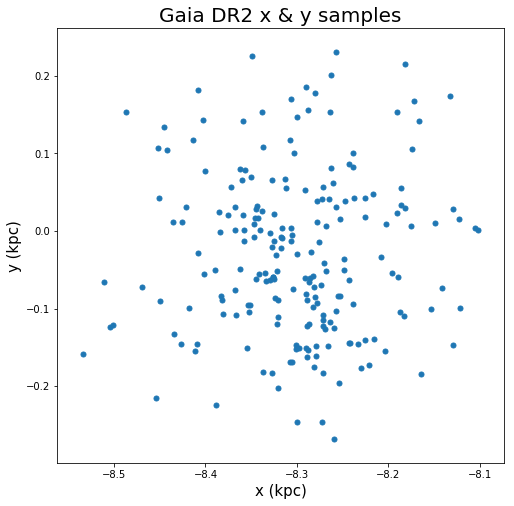

In [2]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
plt.scatter(samples[:,0], samples[:,1], s=25)
plt.title("Gaia DR2 x & y samples", fontsize=20)
plt.xlabel('x (kpc)', fontsize = 15)
plt.ylabel('y (kpc)', fontsize = 15)
plt.show()

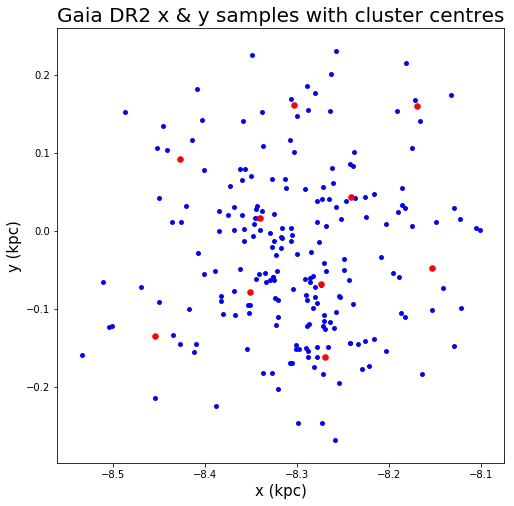

In [3]:
from sklearn.cluster import KMeans

my_kmeans = KMeans(n_clusters=10)  # create KMeans object
my_kmeans.fit(samples[:, :2])  # perform KMeans fitting function

fig = plt.figure(figsize=(8, 8))
plt.scatter(samples[:,0], samples[:,1], s=15, c='blue')
plt.scatter(my_kmeans.cluster_centers_[:, 0],
            my_kmeans.cluster_centers_[:, 1],s=30, c='red')
plt.title("Gaia DR2 x & y samples with cluster centres", fontsize=20)
plt.xlabel('x (kpc)', fontsize = 15)
plt.ylabel('y (kpc)', fontsize = 15)
plt.show()

Above in red are the clusters that the KMeans algorithm produced.
You may be wondering how the Voronoi Tesselations end up. Below is the same plot except cluster centres are denoted by black crosses, and each data point is color-coded to show different regions in the Voronoi Tesselation.

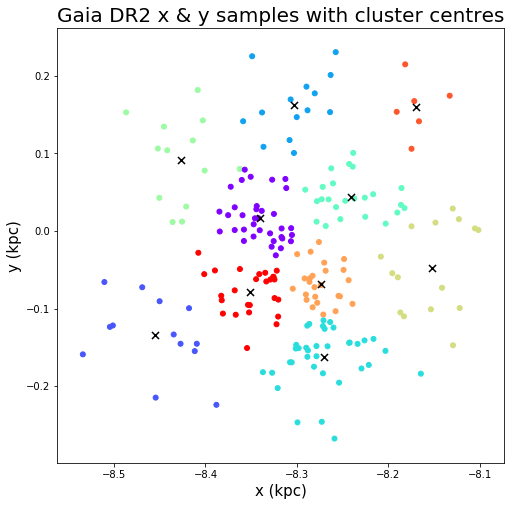

In [4]:
import numpy as np

cmap = plt.get_cmap("rainbow")
colours = cmap(np.linspace(0, 1, 10))

fig = plt.figure(figsize=(8, 8))
plt.scatter(samples[:,0], samples[:,1], s=25, c=colours[my_kmeans.labels_])
plt.scatter(my_kmeans.cluster_centers_[:, 0],
            my_kmeans.cluster_centers_[:, 1], s = 50, marker='x', c='black')
plt.title("Gaia DR2 x & y samples with cluster centres", fontsize=20)
plt.xlabel('x (kpc)', fontsize=15)
plt.ylabel('y (kpc)', fontsize=15)
plt.show()

Let's add the z dimension and visualize this in 3D

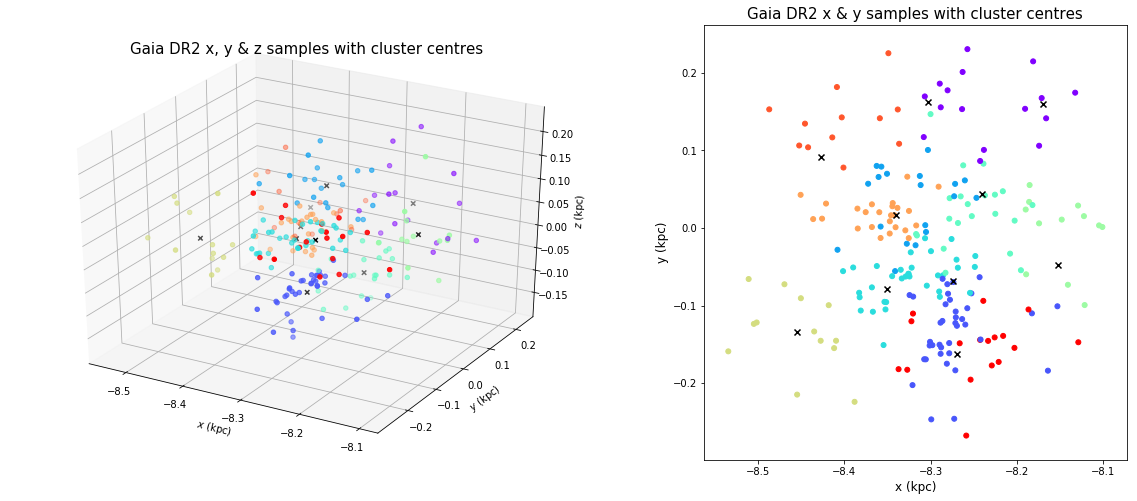

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

my_kmeans_3D = KMeans(n_clusters=10)
my_kmeans_3D.fit(samples[:, :3])

fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.4, 1]) 

ax = fig.add_subplot(gs[0], projection='3d')
ax.scatter(*samples.transpose()[:3], s=20, c=colours[my_kmeans_3D.labels_])
ax.scatter(*my_kmeans_3D.cluster_centers_.transpose()[:3], marker='x', c='black')
ax.set_title("Gaia DR2 x, y & z samples with cluster centres", fontsize=15)
ax.set_xlabel('$x$ (kpc)')
ax.set_ylabel('$y$ (kpc)')
ax.set_zlabel('$z$ (kpc)')

ax1 = fig.add_subplot(gs[1])
plt.scatter(samples[:,0], samples[:,1], s=25, c=colours[my_kmeans_3D.labels_])
plt.scatter(my_kmeans.cluster_centers_[:, 0],
            my_kmeans.cluster_centers_[:, 1], marker='x', c='black')
plt.title("Gaia DR2 x & y samples with cluster centres", fontsize=15)
plt.xlabel('x (kpc)', fontsize=12)
plt.ylabel('y (kpc)', fontsize=12)


plt.show()

There is an underlying assumption we are making with the input data. That in each dimension, the variance is relatively similar. Or in other words, the spread of data in each axis is relatively similar. However, since KMeans heavily relies on Euclidean distance calculations, a dimension with very sparse values can bear more weight on the clustering algorithm than it should. 

We will explain this by first showing the distribution of data as 6 1D histograms.

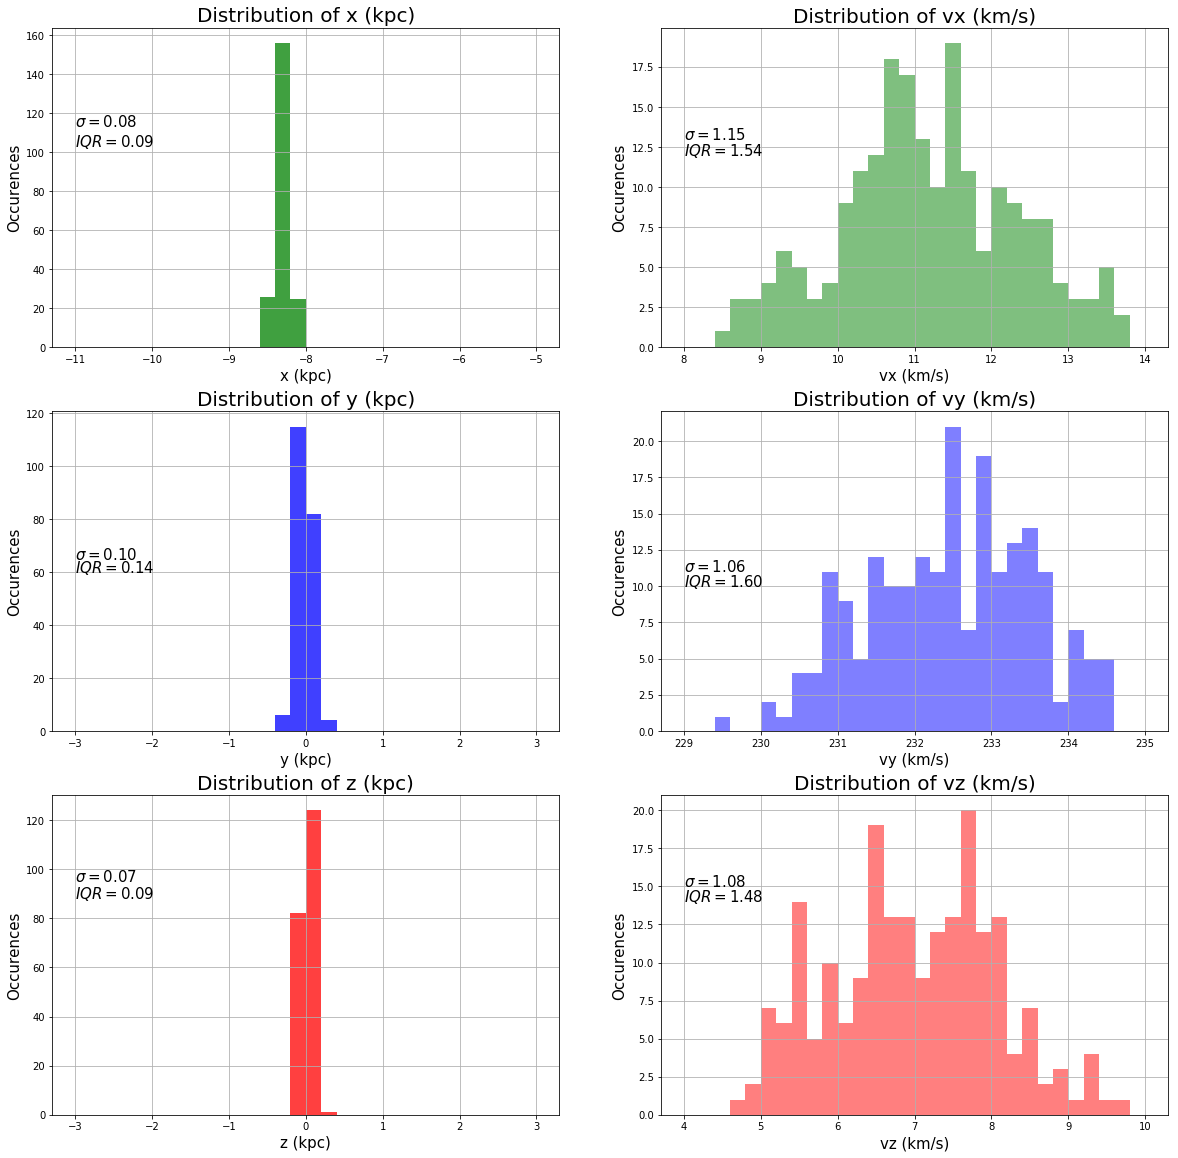

In [6]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from scipy.stats import iqr
import numpy as np

fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(3, 2) 

ax1 = fig.add_subplot(gs[0])
std_x = np.std(samples[:, 0])
iqr_x = iqr(samples[:, 0])

n, bins, patches = plt.hist(samples[:, 0].flatten(), bins=30, range=(-11, -5), facecolor='green', alpha=0.75)
plt.xlabel('x (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.text(-11, 113, r'$\sigma={:.2f}$'.format(std_x), fontsize=15)
plt.text(-11, 103, r'$IQR={:.2f}$'.format(iqr_x), fontsize=15)
plt.title('Distribution of x (kpc)', fontsize=20)

plt.grid(True)

ax2 = fig.add_subplot(gs[1])
std_vx = np.std(samples[:, 3])
iqr_vx = iqr(samples[:, 3])

n, bins, patches = plt.hist(samples[:, 3].flatten(), bins=30, range=(8, 14), facecolor='green', alpha=0.5)
plt.xlabel('vx (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.text(8, 13, r'$\sigma={:.2f}$'.format(std_vx), fontsize=15)
plt.text(8, 12, r'$IQR={:.2f}$'.format(iqr_vx), fontsize=15)
plt.title('Distribution of vx (km/s)', fontsize=20)
plt.grid(True)

ax3 = fig.add_subplot(gs[2])
std_y = np.std(samples[:, 1])
iqr_y = iqr(samples[:, 1])

n, bins, patches = plt.hist(samples[:, 1].flatten(), bins=30, range=(-3, 3), facecolor='blue', alpha=0.75)
plt.xlabel('y (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.text(-3, 65, r'$\sigma={:.2f}$'.format(std_y), fontsize=15)
plt.text(-3, 60, r'$IQR={:.2f}$'.format(iqr_y), fontsize=15)
plt.title('Distribution of y (kpc)', fontsize=20)
plt.grid(True)

ax4 = fig.add_subplot(gs[3])
std_vy = np.std(samples[:, 4])
iqr_vy = iqr(samples[:, 4])

n, bins, patches = plt.hist(samples[:, 4].flatten(), bins=30, range=(229, 235), facecolor='blue', alpha=0.5)
plt.xlabel('vy (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.text(229, 11, r'$\sigma={:.2f}$'.format(std_vy), fontsize=15)
plt.text(229, 10, r'$IQR={:.2f}$'.format(iqr_vy), fontsize=15)
plt.title('Distribution of vy (km/s)', fontsize=20)
plt.grid(True)

ax5 = fig.add_subplot(gs[4])
std_z = np.std(samples[:, 2])
iqr_z = iqr(samples[:, 2])

n, bins, patches = plt.hist(samples[:, 2].flatten(), bins=30, range=(-3,3), facecolor='red', alpha=0.75)
plt.xlabel('z (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.text(-3, 95, r'$\sigma={:.2f}$'.format(std_z), fontsize=15)
plt.text(-3, 88, r'$IQR={:.2f}$'.format(iqr_x), fontsize=15)
plt.title('Distribution of z (kpc)', fontsize=20)
plt.grid(True)

ax6 = fig.add_subplot(gs[5])
std_vz = np.std(samples[:, 5])
iqr_vz = iqr(samples[:, 5])

n, bins, patches = plt.hist(samples[:, 5].flatten(), bins=30, range=(4,10), facecolor='red', alpha=0.5)
plt.xlabel('vz (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.text(4, 15, r'$\sigma={:.2f}$'.format(std_vz), fontsize=15)
plt.text(4, 14, r'$IQR={:.2f}$'.format(iqr_vz), fontsize=15)
plt.title('Distribution of vz (km/s)', fontsize=20)
plt.grid(True)

plt.show()

The x, y and z graphs look off, and that is due to the fact the range the same for each dimesion, at 6. To fix this, we first multiplied each velocity component by a constant cluster_scale and produced these results:
<img src="Defining_kmeans_images/cluster0.01.png">
<img src="Defining_kmeans_images/cluster0.20.png">

Notice that when cluster_scale is above 0.20, velocities skew the KMeans clustering and when cluster_scale is too look at 0.01, positions dominate KMeans clustering. Our initial idea was to find an ideal cluster_scale such that both positions and velocities were equally distributed. We found that 0.06 worked.

<img src="Defining_kmeans_images/cluster0.20.png">

The only problem is that still, the distribution of each velocity component is still different. Dividing each velocity by the same number does not change the relative distribution and is rather naive. We will also try dividing each component by its IQR and standard deviation. The standard methods seems to be dividing by standard deviation which values in z-score. A potential improvement would be dividing by IQR handles outliers that would skew normally standard deviation. 

First we will multiply each dimension by cluster_scale = 0.06 and plot the data. Note each "6-pack" of graphs will have the same range and bin number for visual comparison. We want to study how well each histogram has matching ranges. From that, we will determine which scaling technique is optimal.

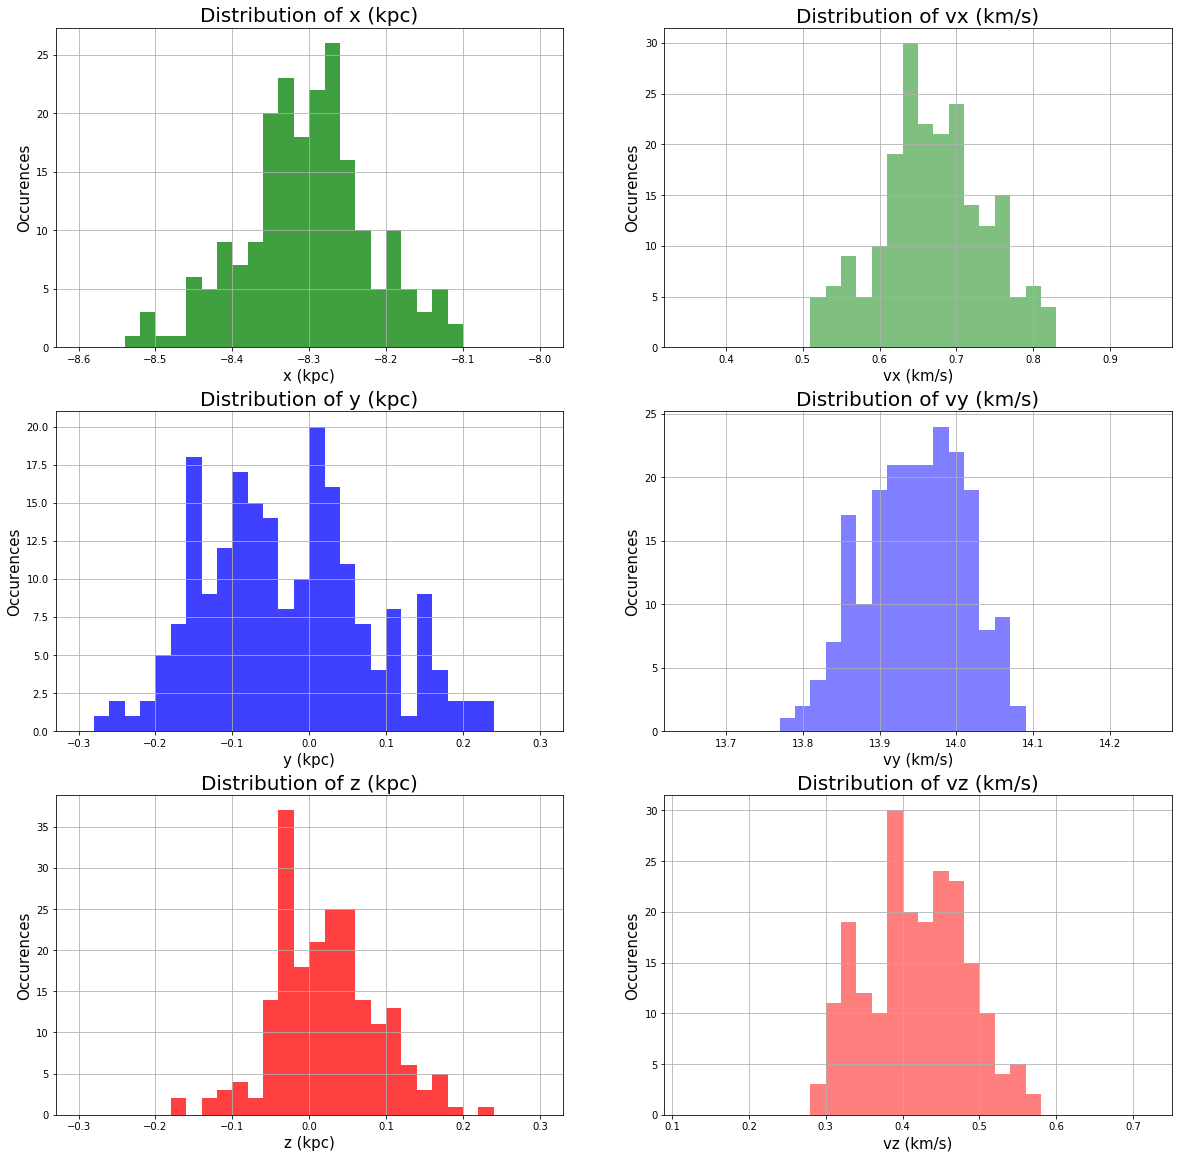

In [7]:
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(3, 2) 

ax1 = fig.add_subplot(gs[0])
std_x = np.std(samples[:, 0])
iqr_x = iqr(samples[:, 0])

n, bins, patches = plt.hist(samples[:, 0].flatten(), bins=30, range=(-8.6, -8), facecolor='green', alpha=0.75)
plt.xlabel('x (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
#plt.text(-11, 113, r'$\sigma={:.2f}$'.format(std_x), fontsize=15)
#plt.text(-11, 103, r'$IQR={:.2f}$'.format(iqr_x), fontsize=15)
plt.title('Distribution of x (kpc)', fontsize=20)

plt.grid(True)

ax2 = fig.add_subplot(gs[1])
std_vx = np.std(samples[:, 3])
iqr_vx = iqr(samples[:, 3])

n, bins, patches = plt.hist(np.multiply(samples[:, 3].flatten(), 0.06), bins=30, range=(0.35, 0.95), facecolor='green', alpha=0.5)
plt.xlabel('vx (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
#plt.text(8, 13, r'$\sigma={:.2f}$'.format(std_vx), fontsize=15)
#plt.text(8, 12, r'$IQR={:.2f}$'.format(iqr_vx), fontsize=15)
plt.title('Distribution of vx (km/s)', fontsize=20)
plt.grid(True)

ax3 = fig.add_subplot(gs[2])
std_y = np.std(samples[:, 1])
iqr_y = iqr(samples[:, 1])

n, bins, patches = plt.hist(samples[:, 1].flatten(), bins=30, range=(-0.3, 0.3), facecolor='blue', alpha=0.75)
plt.xlabel('y (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
#plt.text(-3, 65, r'$\sigma={:.2f}$'.format(std_y), fontsize=15)
#plt.text(-3, 60, r'$IQR={:.2f}$'.format(iqr_y), fontsize=15)
plt.title('Distribution of y (kpc)', fontsize=20)
plt.grid(True)

ax4 = fig.add_subplot(gs[3])
std_vy = np.std(samples[:, 4])
iqr_vy = iqr(samples[:, 4])

n, bins, patches = plt.hist(np.multiply(samples[:, 4].flatten(), 0.06), bins=30, range=(13.65, 14.25), facecolor='blue', alpha=0.5)
plt.xlabel('vy (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
#plt.text(229, 11, r'$\sigma={:.2f}$'.format(std_vy), fontsize=15)
#plt.text(229, 10, r'$IQR={:.2f}$'.format(iqr_vy), fontsize=15)
plt.title('Distribution of vy (km/s)', fontsize=20)
plt.grid(True)

ax5 = fig.add_subplot(gs[4])
std_z = np.std(samples[:, 2])
iqr_z = iqr(samples[:, 2])

n, bins, patches = plt.hist(samples[:, 2].flatten(), bins=30, range=(-0.3, 0.3), facecolor='red', alpha=0.75)
plt.xlabel('z (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
#plt.text(-3, 95, r'$\sigma={:.2f}$'.format(std_z), fontsize=15)
#plt.text(-3, 88, r'$IQR={:.2f}$'.format(iqr_x), fontsize=15)
plt.title('Distribution of z (kpc)', fontsize=20)
plt.grid(True)

ax6 = fig.add_subplot(gs[5])
std_vz = np.std(samples[:, 5])
iqr_vz = iqr(samples[:, 5])

n, bins, patches = plt.hist(np.multiply(samples[:, 5].flatten(), 0.06), bins=30, range=(0.12, 0.72), facecolor='red', alpha=0.5)
plt.xlabel('vz (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
#plt.text(4, 15, r'$\sigma={:.2f}$'.format(std_vz), fontsize=15)
#plt.text(4, 14, r'$IQR={:.2f}$'.format(iqr_vz), fontsize=15)
plt.title('Distribution of vz (km/s)', fontsize=20)
plt.grid(True)

plt.show()


Next we will divide each dimension by standard deviation and plot the data. This creates a histograms of each dimension's z-score centred on its mean.

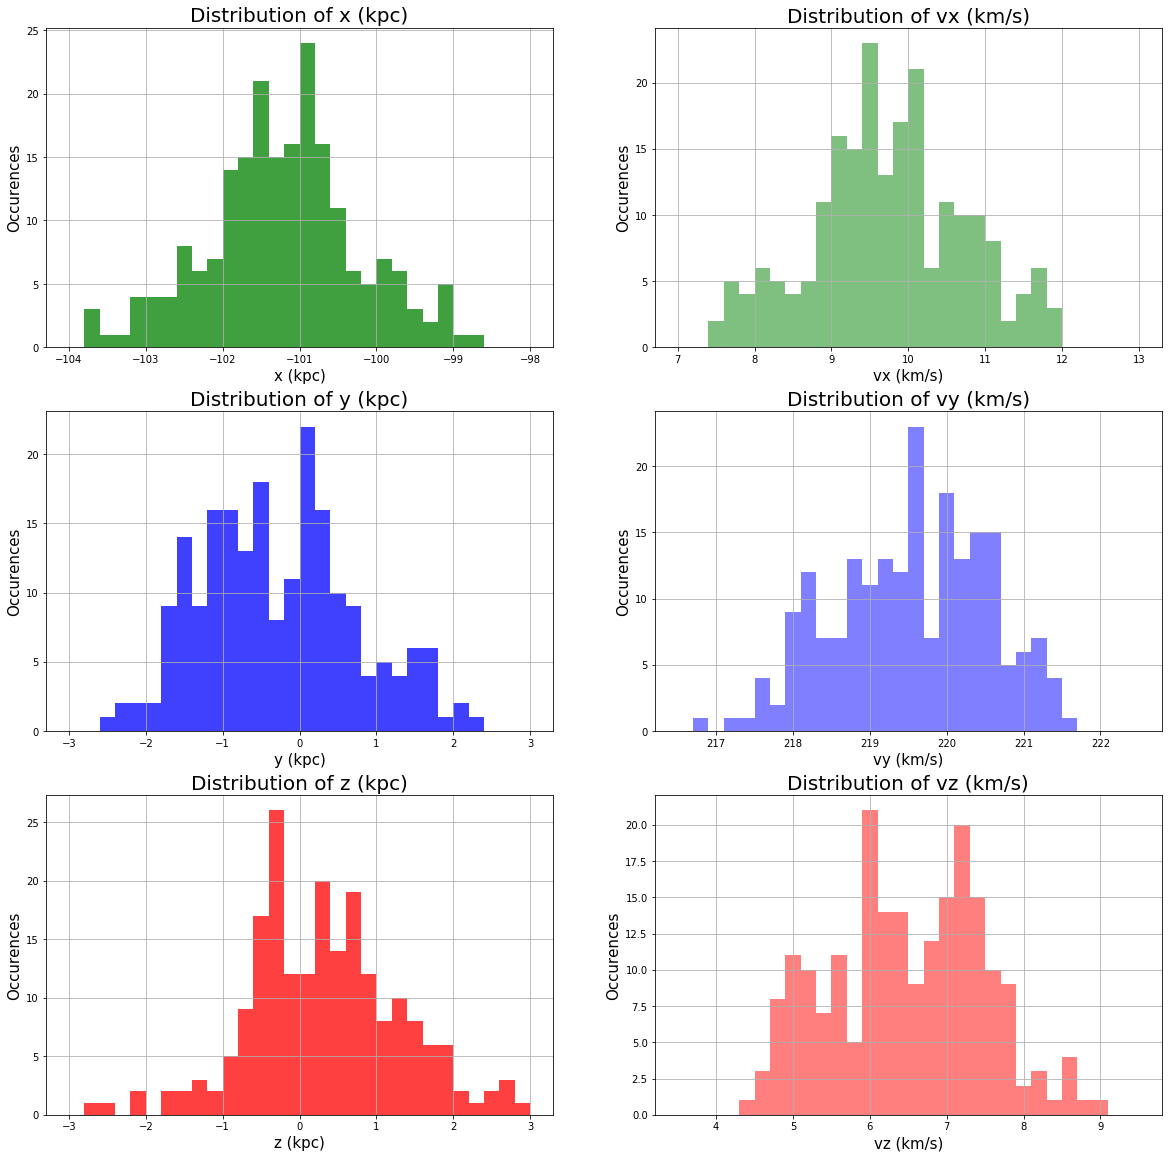

In [8]:
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(3, 2) 

ax1 = fig.add_subplot(gs[0])
std_x = np.std(samples[:, 0])
iqr_x = iqr(samples[:, 0])

n, bins, patches = plt.hist(np.divide(samples[:, 0].flatten(), std_x), bins=30, range=(-104, -98), facecolor='green', alpha=0.75)
plt.xlabel('x (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
#plt.text(-11, 113, r'$\sigma={:.2f}$'.format(std_x), fontsize=15)
#plt.text(-11, 103, r'$IQR={:.2f}$'.format(iqr_x), fontsize=15)
plt.title('Distribution of x (kpc)', fontsize=20)

plt.grid(True)

ax2 = fig.add_subplot(gs[1])
std_vx = np.std(samples[:, 3])
iqr_vx = iqr(samples[:, 3])

n, bins, patches = plt.hist(np.divide(samples[:, 3].flatten(), std_vx), bins=30, range=(7, 13), facecolor='green', alpha=0.5)
plt.xlabel('vx (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
#plt.text(8, 13, r'$\sigma={:.2f}$'.format(std_vx), fontsize=15)
#plt.text(8, 12, r'$IQR={:.2f}$'.format(iqr_vx), fontsize=15)
plt.title('Distribution of vx (km/s)', fontsize=20)
plt.grid(True)

ax3 = fig.add_subplot(gs[2])
std_y = np.std(samples[:, 1])
iqr_y = iqr(samples[:, 1])

n, bins, patches = plt.hist(np.divide(samples[:, 1].flatten(), std_y), bins=30, range=(-3, 3), facecolor='blue', alpha=0.75)
plt.xlabel('y (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
#plt.text(-3, 65, r'$\sigma={:.2f}$'.format(std_y), fontsize=15)
#plt.text(-3, 60, r'$IQR={:.2f}$'.format(iqr_y), fontsize=15)
plt.title('Distribution of y (kpc)', fontsize=20)
plt.grid(True)

ax4 = fig.add_subplot(gs[3])
std_vy = np.std(samples[:, 4])
iqr_vy = iqr(samples[:, 4])

n, bins, patches = plt.hist(np.divide(samples[:, 4].flatten(), std_vy), bins=30, range=(216.5, 222.5), facecolor='blue', alpha=0.5)
plt.xlabel('vy (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
#plt.text(229, 11, r'$\sigma={:.2f}$'.format(std_vy), fontsize=15)
#plt.text(229, 10, r'$IQR={:.2f}$'.format(iqr_vy), fontsize=15)
plt.title('Distribution of vy (km/s)', fontsize=20)
plt.grid(True)

ax5 = fig.add_subplot(gs[4])
std_z = np.std(samples[:, 2])
iqr_z = iqr(samples[:, 2])

n, bins, patches = plt.hist(np.divide(samples[:, 2].flatten(), std_z), bins=30, range=(-3, 3), facecolor='red', alpha=0.75)
plt.xlabel('z (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
#plt.text(-3, 95, r'$\sigma={:.2f}$'.format(std_z), fontsize=15)
#plt.text(-3, 88, r'$IQR={:.2f}$'.format(iqr_x), fontsize=15)
plt.title('Distribution of z (kpc)', fontsize=20)
plt.grid(True)

ax6 = fig.add_subplot(gs[5])
std_vz = np.std(samples[:, 5])
iqr_vz = iqr(samples[:, 5])

n, bins, patches = plt.hist(np.divide(samples[:, 5].flatten(), std_vz), bins=30, range=(3.5, 9.5), facecolor='red', alpha=0.5)
plt.xlabel('vz (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
#plt.text(4, 15, r'$\sigma={:.2f}$'.format(std_vz), fontsize=15)
#plt.text(4, 14, r'$IQR={:.2f}$'.format(iqr_vz), fontsize=15)
plt.title('Distribution of vz (km/s)', fontsize=20)
plt.grid(True)

plt.show()


Thirdly, we will divide each dimension by its IQR and plot the data.

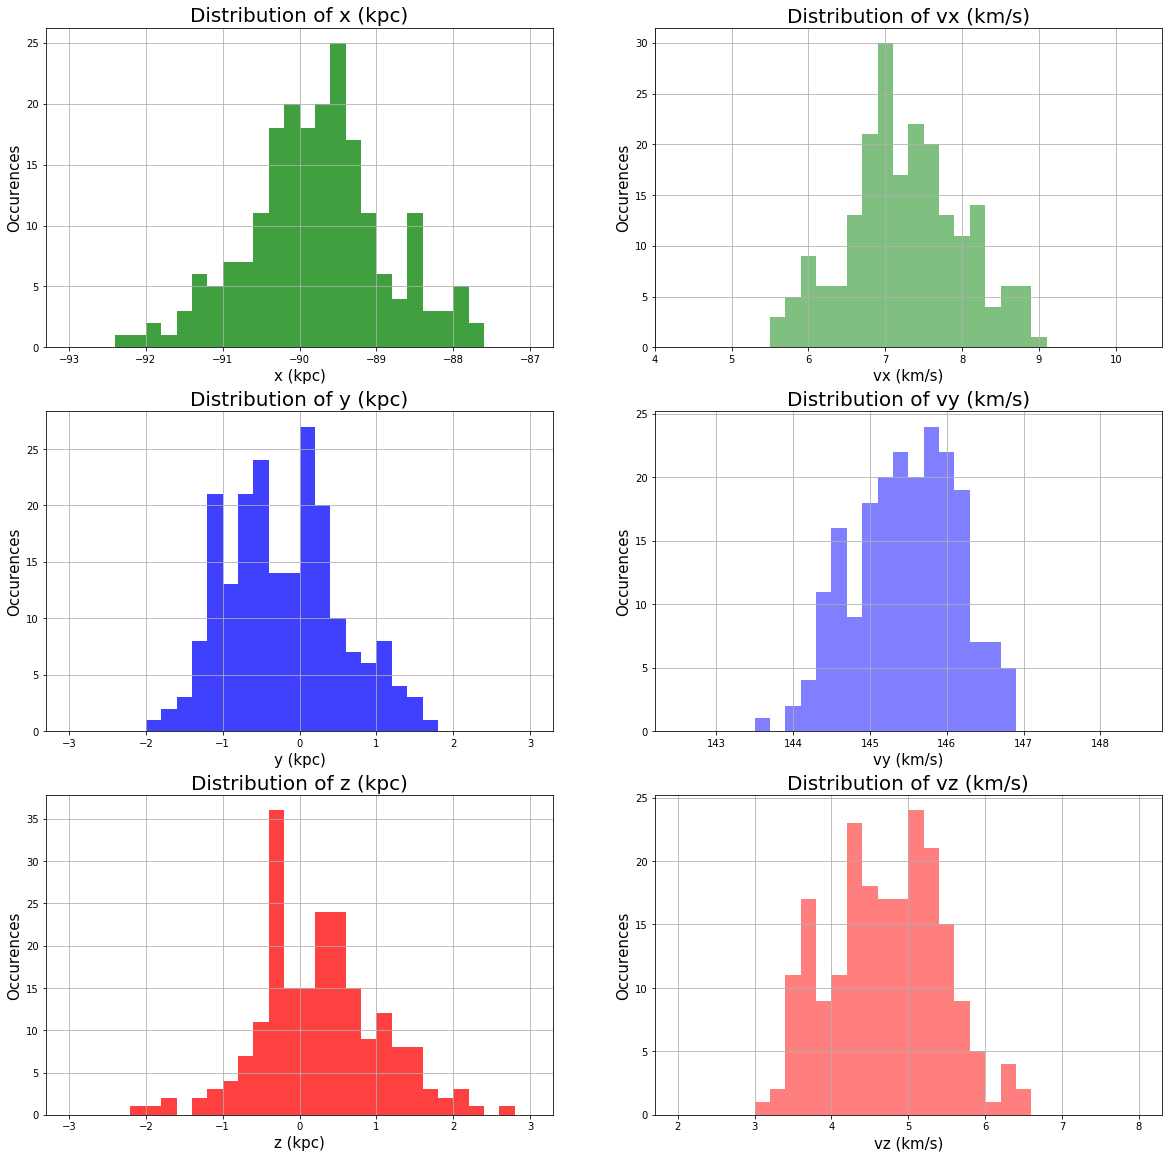

In [9]:
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(3, 2) 

ax1 = fig.add_subplot(gs[0])
std_x = np.std(samples[:, 0])
iqr_x = iqr(samples[:, 0])

n, bins, patches = plt.hist(np.divide(samples[:, 0].flatten(), iqr_x), bins=30, range=(-93, -87), facecolor='green', alpha=0.75)
plt.xlabel('x (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
#plt.text(-11, 113, r'$\sigma={:.2f}$'.format(std_x), fontsize=15)
#plt.text(-11, 103, r'$IQR={:.2f}$'.format(iqr_x), fontsize=15)
plt.title('Distribution of x (kpc)', fontsize=20)

plt.grid(True)

ax2 = fig.add_subplot(gs[1])
std_vx = np.std(samples[:, 3])
iqr_vx = iqr(samples[:, 3])

n, bins, patches = plt.hist(np.divide(samples[:, 3].flatten(), iqr_vx), bins=30, range=(4.3, 10.3), facecolor='green', alpha=0.5)
plt.xlabel('vx (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
#plt.text(8, 13, r'$\sigma={:.2f}$'.format(std_vx), fontsize=15)
#plt.text(8, 12, r'$IQR={:.2f}$'.format(iqr_vx), fontsize=15)
plt.title('Distribution of vx (km/s)', fontsize=20)
plt.grid(True)

ax3 = fig.add_subplot(gs[2])
std_y = np.std(samples[:, 1])
iqr_y = iqr(samples[:, 1])

n, bins, patches = plt.hist(np.divide(samples[:, 1].flatten(), iqr_y), bins=30, range=(-3, 3), facecolor='blue', alpha=0.75)
plt.xlabel('y (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
#plt.text(-3, 65, r'$\sigma={:.2f}$'.format(std_y), fontsize=15)
#plt.text(-3, 60, r'$IQR={:.2f}$'.format(iqr_y), fontsize=15)
plt.title('Distribution of y (kpc)', fontsize=20)
plt.grid(True)

ax4 = fig.add_subplot(gs[3])
std_vy = np.std(samples[:, 4])
iqr_vy = iqr(samples[:, 4])

n, bins, patches = plt.hist(np.divide(samples[:, 4].flatten(), iqr_vy), bins=30, range=(142.5, 148.5), facecolor='blue', alpha=0.5)
plt.xlabel('vy (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
#plt.text(229, 11, r'$\sigma={:.2f}$'.format(std_vy), fontsize=15)
#plt.text(229, 10, r'$IQR={:.2f}$'.format(iqr_vy), fontsize=15)
plt.title('Distribution of vy (km/s)', fontsize=20)
plt.grid(True)

ax5 = fig.add_subplot(gs[4])
std_z = np.std(samples[:, 2])
iqr_z = iqr(samples[:, 2])

n, bins, patches = plt.hist(np.divide(samples[:, 2].flatten(), iqr_z), bins=30, range=(-3, 3), facecolor='red', alpha=0.75)
plt.xlabel('z (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
#plt.text(-3, 95, r'$\sigma={:.2f}$'.format(std_z), fontsize=15)
#plt.text(-3, 88, r'$IQR={:.2f}$'.format(iqr_x), fontsize=15)
plt.title('Distribution of z (kpc)', fontsize=20)
plt.grid(True)

ax6 = fig.add_subplot(gs[5])
std_vz = np.std(samples[:, 5])
iqr_vz = iqr(samples[:, 5])

n, bins, patches = plt.hist(np.divide(samples[:, 5].flatten(), iqr_vz), bins=30, range=(2, 8), facecolor='red', alpha=0.5)
plt.xlabel('vz (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
#plt.text(4, 15, r'$\sigma={:.2f}$'.format(std_vz), fontsize=15)
#plt.text(4, 14, r'$IQR={:.2f}$'.format(iqr_vz), fontsize=15)
plt.title('Distribution of vz (km/s)', fontsize=20)
plt.grid(True)

plt.show()


Let's plot them all together.

Left Column: cluster_scale

Middle Column: standard deviation

Right Column: IQR

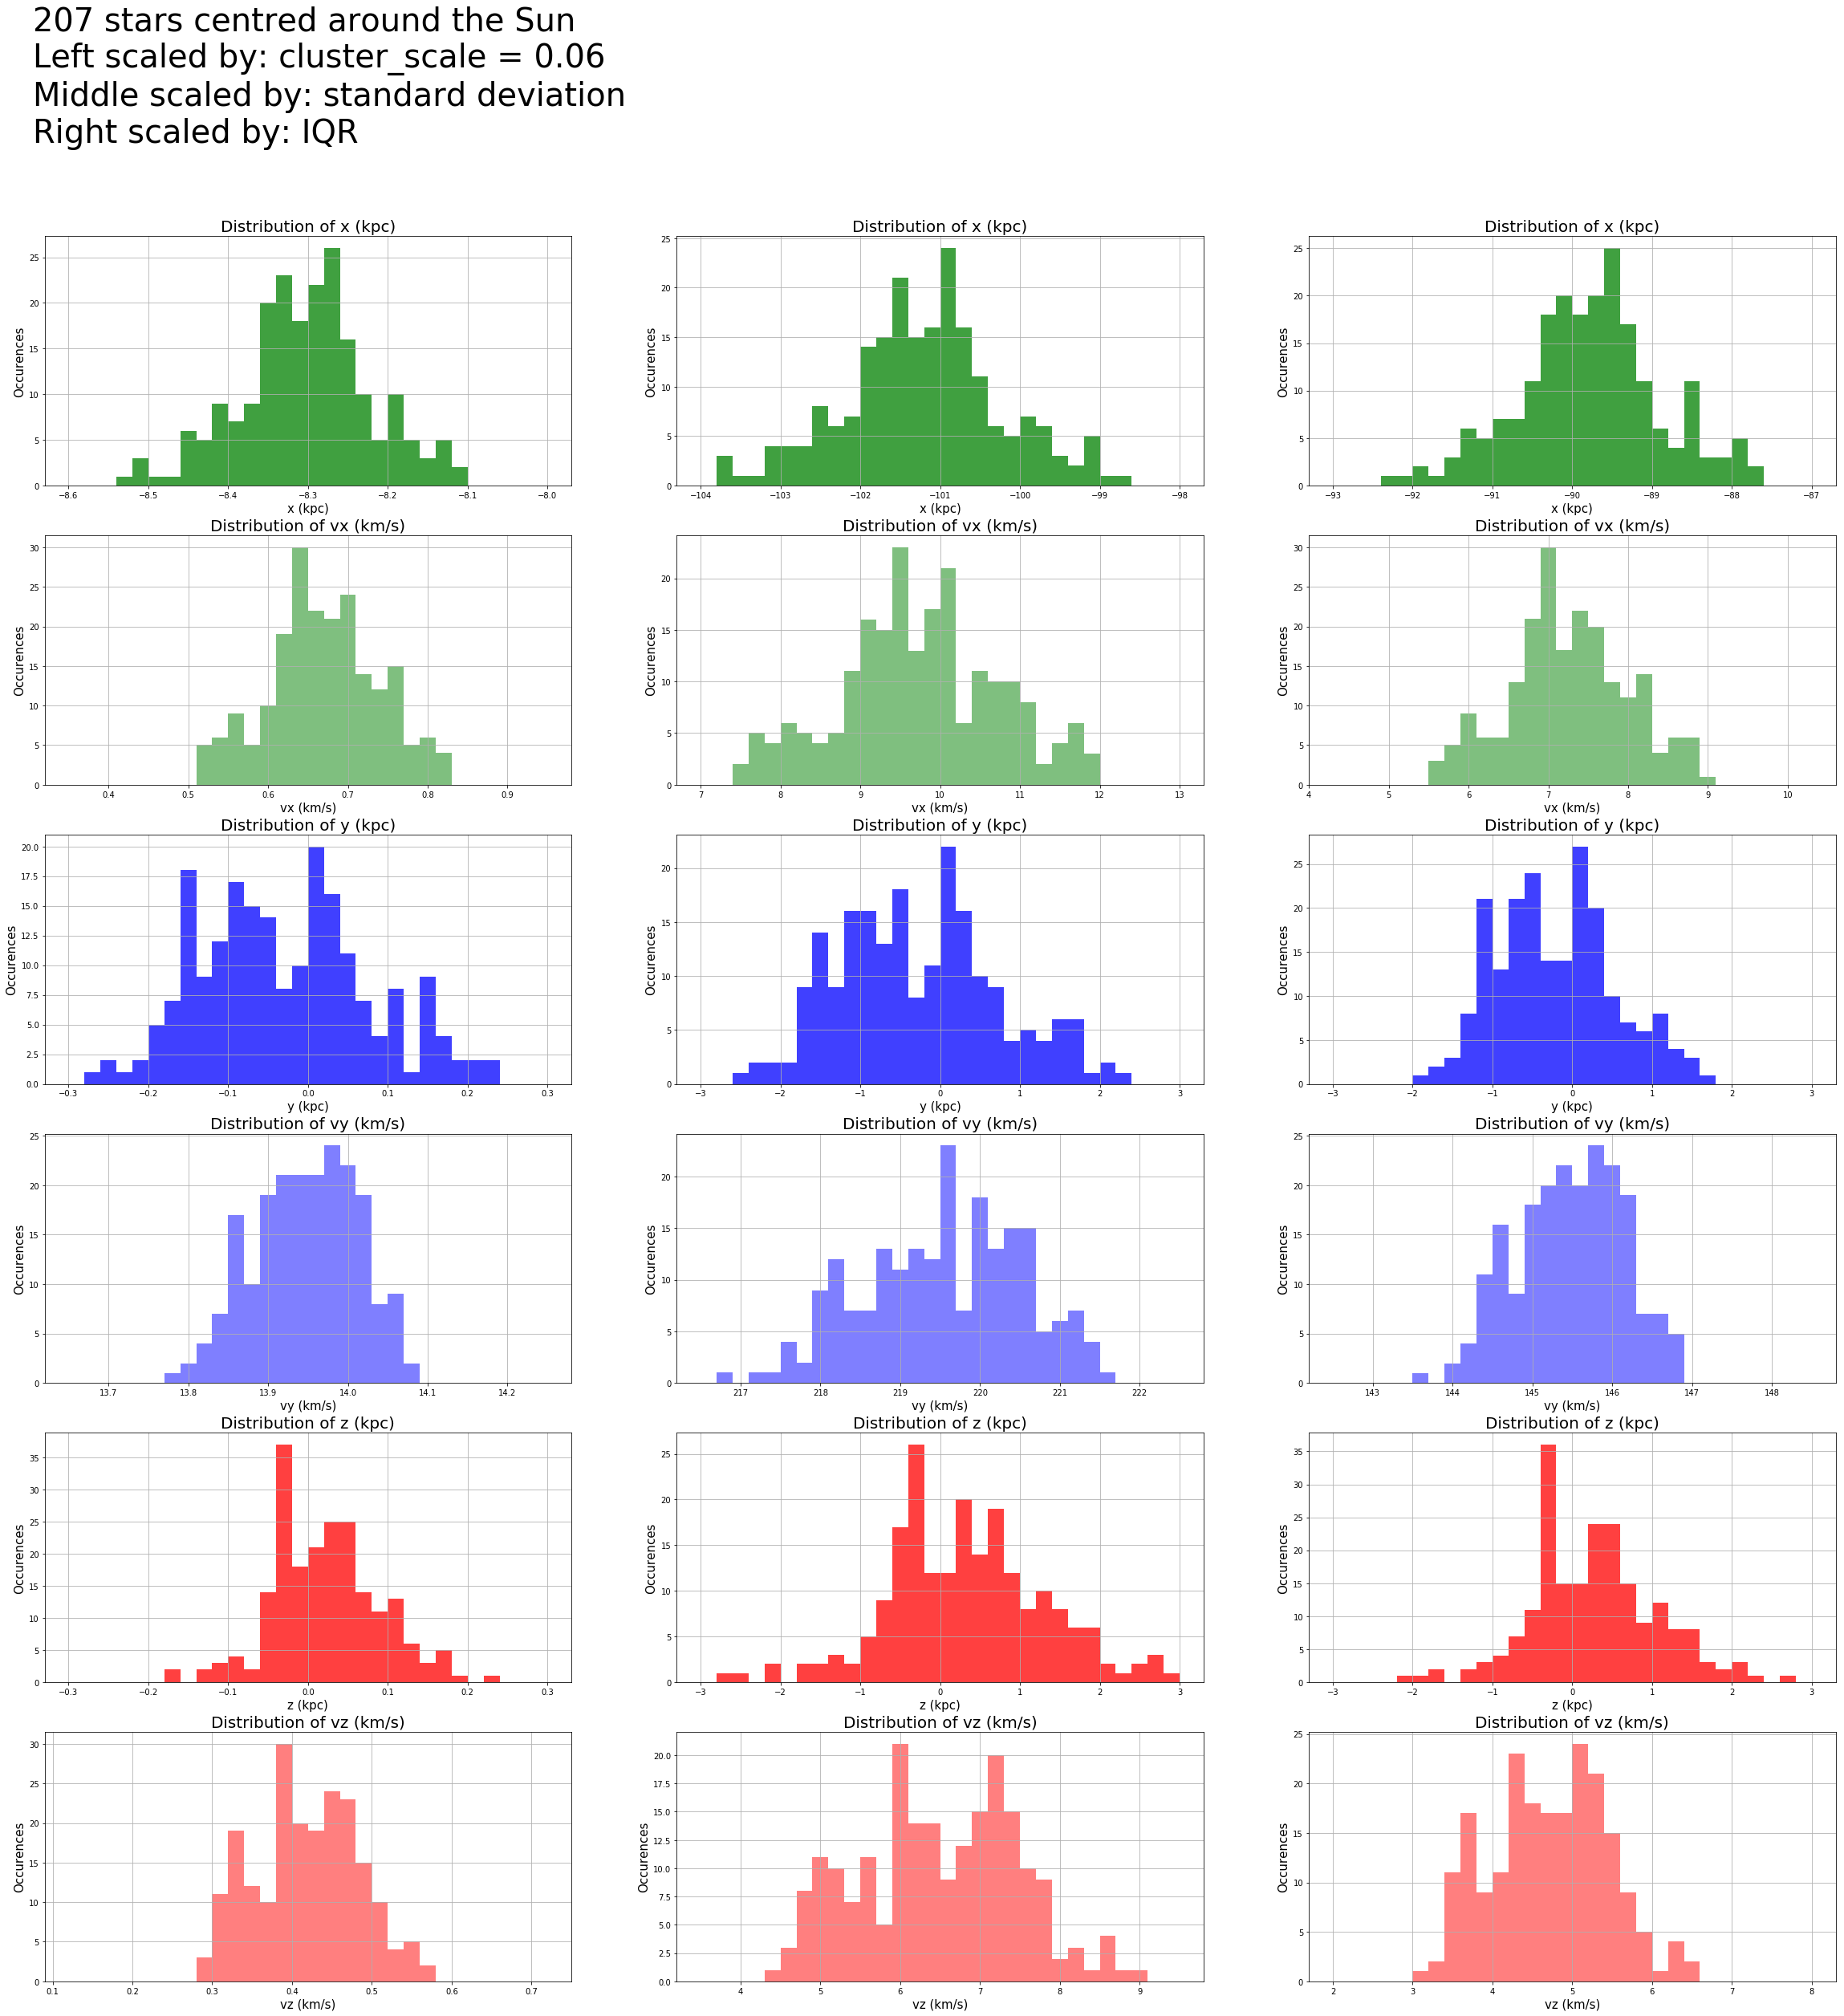

In [63]:
fig = plt.figure(figsize=(40, 40))
gs = gridspec.GridSpec(6, 3) 
fig.suptitle("207 stars centred around the Sun \nLeft scaled by: cluster_scale = 0.06 \nMiddle scaled by: standard deviation \nRight scaled by: IQR", fontsize=40, horizontalalignment='left', x=0.12)

#
# ROW 1(x)
#

std_x = np.std(samples[:, 0])
iqr_x = iqr(samples[:, 0])

ax1 = fig.add_subplot(gs[0])
n, bins, patches = plt.hist(samples[:, 0].flatten(), bins=30, range=(-8.6, -8), facecolor='green', alpha=0.75)
plt.xlabel('x (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of x (kpc)', fontsize=20)
plt.grid(True)

ax2 = fig.add_subplot(gs[1])
n, bins, patches = plt.hist(np.divide(samples[:, 0].flatten(), std_x), bins=30, range=(-104, -98), facecolor='green', alpha=0.75)
plt.xlabel('x (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of x (kpc)', fontsize=20)
plt.grid(True)

ax3 = fig.add_subplot(gs[2])
n, bins, patches = plt.hist(np.divide(samples[:, 0].flatten(), iqr_x), bins=30, range=(-93, -87), facecolor='green', alpha=0.75)
plt.xlabel('x (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of x (kpc)', fontsize=20)
plt.grid(True)


#
# ROW 2(vx)
#

std_vx = np.std(samples[:, 3])
iqr_vx = iqr(samples[:, 3])

ax4 = fig.add_subplot(gs[3])
n, bins, patches = plt.hist(np.multiply(samples[:, 3].flatten(), 0.06), bins=30, range=(0.35, 0.95), facecolor='green', alpha=0.5)
plt.xlabel('vx (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of vx (km/s)', fontsize=20)
plt.grid(True)

ax5 = fig.add_subplot(gs[4])
n, bins, patches = plt.hist(np.divide(samples[:, 3].flatten(), std_vx), bins=30, range=(7, 13), facecolor='green', alpha=0.5)
plt.xlabel('vx (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of vx (km/s)', fontsize=20)
plt.grid(True)

ax6 = fig.add_subplot(gs[5])
n, bins, patches = plt.hist(np.divide(samples[:, 3].flatten(), iqr_vx), bins=30, range=(4.3, 10.3), facecolor='green', alpha=0.5)
plt.xlabel('vx (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of vx (km/s)', fontsize=20)
plt.grid(True)


#
# ROW 3(y)
#

std_y = np.std(samples[:, 1])
iqr_y = iqr(samples[:, 1])

ax7 = fig.add_subplot(gs[6])
n, bins, patches = plt.hist(samples[:, 1].flatten(), bins=30, range=(-0.3, 0.3), facecolor='blue', alpha=0.75)
plt.xlabel('y (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of y (kpc)', fontsize=20)
plt.grid(True)

ax8 = fig.add_subplot(gs[7])
n, bins, patches = plt.hist(np.divide(samples[:, 1].flatten(), std_y), bins=30, range=(-3, 3), facecolor='blue', alpha=0.75)
plt.xlabel('y (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of y (kpc)', fontsize=20)
plt.grid(True)

ax9 = fig.add_subplot(gs[8])
n, bins, patches = plt.hist(np.divide(samples[:, 1].flatten(), iqr_y), bins=30, range=(-3, 3), facecolor='blue', alpha=0.75)
plt.xlabel('y (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of y (kpc)', fontsize=20)
plt.grid(True)


#
# ROW 4(vy)
#

std_vy = np.std(samples[:, 4])
iqr_vy = iqr(samples[:, 4])

ax10 = fig.add_subplot(gs[9])
n, bins, patches = plt.hist(np.multiply(samples[:, 4].flatten(), 0.06), bins=30, range=(13.65, 14.25), facecolor='blue', alpha=0.5)
plt.xlabel('vy (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of vy (km/s)', fontsize=20)
plt.grid(True)

ax11 = fig.add_subplot(gs[10])
n, bins, patches = plt.hist(np.divide(samples[:, 4].flatten(), std_vy), bins=30, range=(216.5, 222.5), facecolor='blue', alpha=0.5)
plt.xlabel('vy (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of vy (km/s)', fontsize=20)
plt.grid(True)

ax12 = fig.add_subplot(gs[11])
n, bins, patches = plt.hist(np.divide(samples[:, 4].flatten(), iqr_vy), bins=30, range=(142.5, 148.5), facecolor='blue', alpha=0.5)
plt.xlabel('vy (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of vy (km/s)', fontsize=20)
plt.grid(True)


#
# ROW 5(z)
#

std_z = np.std(samples[:, 2])
iqr_z = iqr(samples[:, 2])

ax13 = fig.add_subplot(gs[12])
n, bins, patches = plt.hist(samples[:, 2].flatten(), bins=30, range=(-0.3, 0.3), facecolor='red', alpha=0.75)
plt.xlabel('z (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of z (kpc)', fontsize=20)
plt.grid(True)

ax14 = fig.add_subplot(gs[13])
n, bins, patches = plt.hist(np.divide(samples[:, 2].flatten(), std_z), bins=30, range=(-3, 3), facecolor='red', alpha=0.75)
plt.xlabel('z (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of z (kpc)', fontsize=20)
plt.grid(True)

ax15 = fig.add_subplot(gs[14])
n, bins, patches = plt.hist(np.divide(samples[:, 2].flatten(), iqr_z), bins=30, range=(-3, 3), facecolor='red', alpha=0.75)
plt.xlabel('z (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of z (kpc)', fontsize=20)
plt.grid(True)


#
# ROW 6(vz)
#

std_vz = np.std(samples[:, 5])
iqr_vz = iqr(samples[:, 5])

ax16 = fig.add_subplot(gs[15])
n, bins, patches = plt.hist(np.multiply(samples[:, 5].flatten(), 0.06), bins=30, range=(0.12, 0.72), facecolor='red', alpha=0.5)
plt.xlabel('vz (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of vz (km/s)', fontsize=20)
plt.grid(True)

ax17 = fig.add_subplot(gs[16])
n, bins, patches = plt.hist(np.divide(samples[:, 5].flatten(), std_vz), bins=30, range=(3.5, 9.5), facecolor='red', alpha=0.5)
plt.xlabel('vz (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of vz (km/s)', fontsize=20)
plt.grid(True)

ax18 = fig.add_subplot(gs[17])
n, bins, patches = plt.hist(np.divide(samples[:, 5].flatten(), iqr_vz), bins=30, range=(2, 8), facecolor='red', alpha=0.5)
plt.xlabel('vz (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of vz (km/s)', fontsize=20)
plt.grid(True)


plt.show()
fig.savefig("Defining_kmeans_images/comparison_207stars.png")


The reason we want a similar range in data is because KMeans uses spherical clustering due to euclidean distance. Let's try this with more stars. We think using std/iqr as scaling techniques are superior due to its ability to scale axes independantly so we will not be scaling by cluster_scale.

In [56]:
samples_large = search_local.search_phase_space(0, 0, 0, 0, 0, 0, epsilon=1, v_scale=0.1)
len(samples_large)

36745

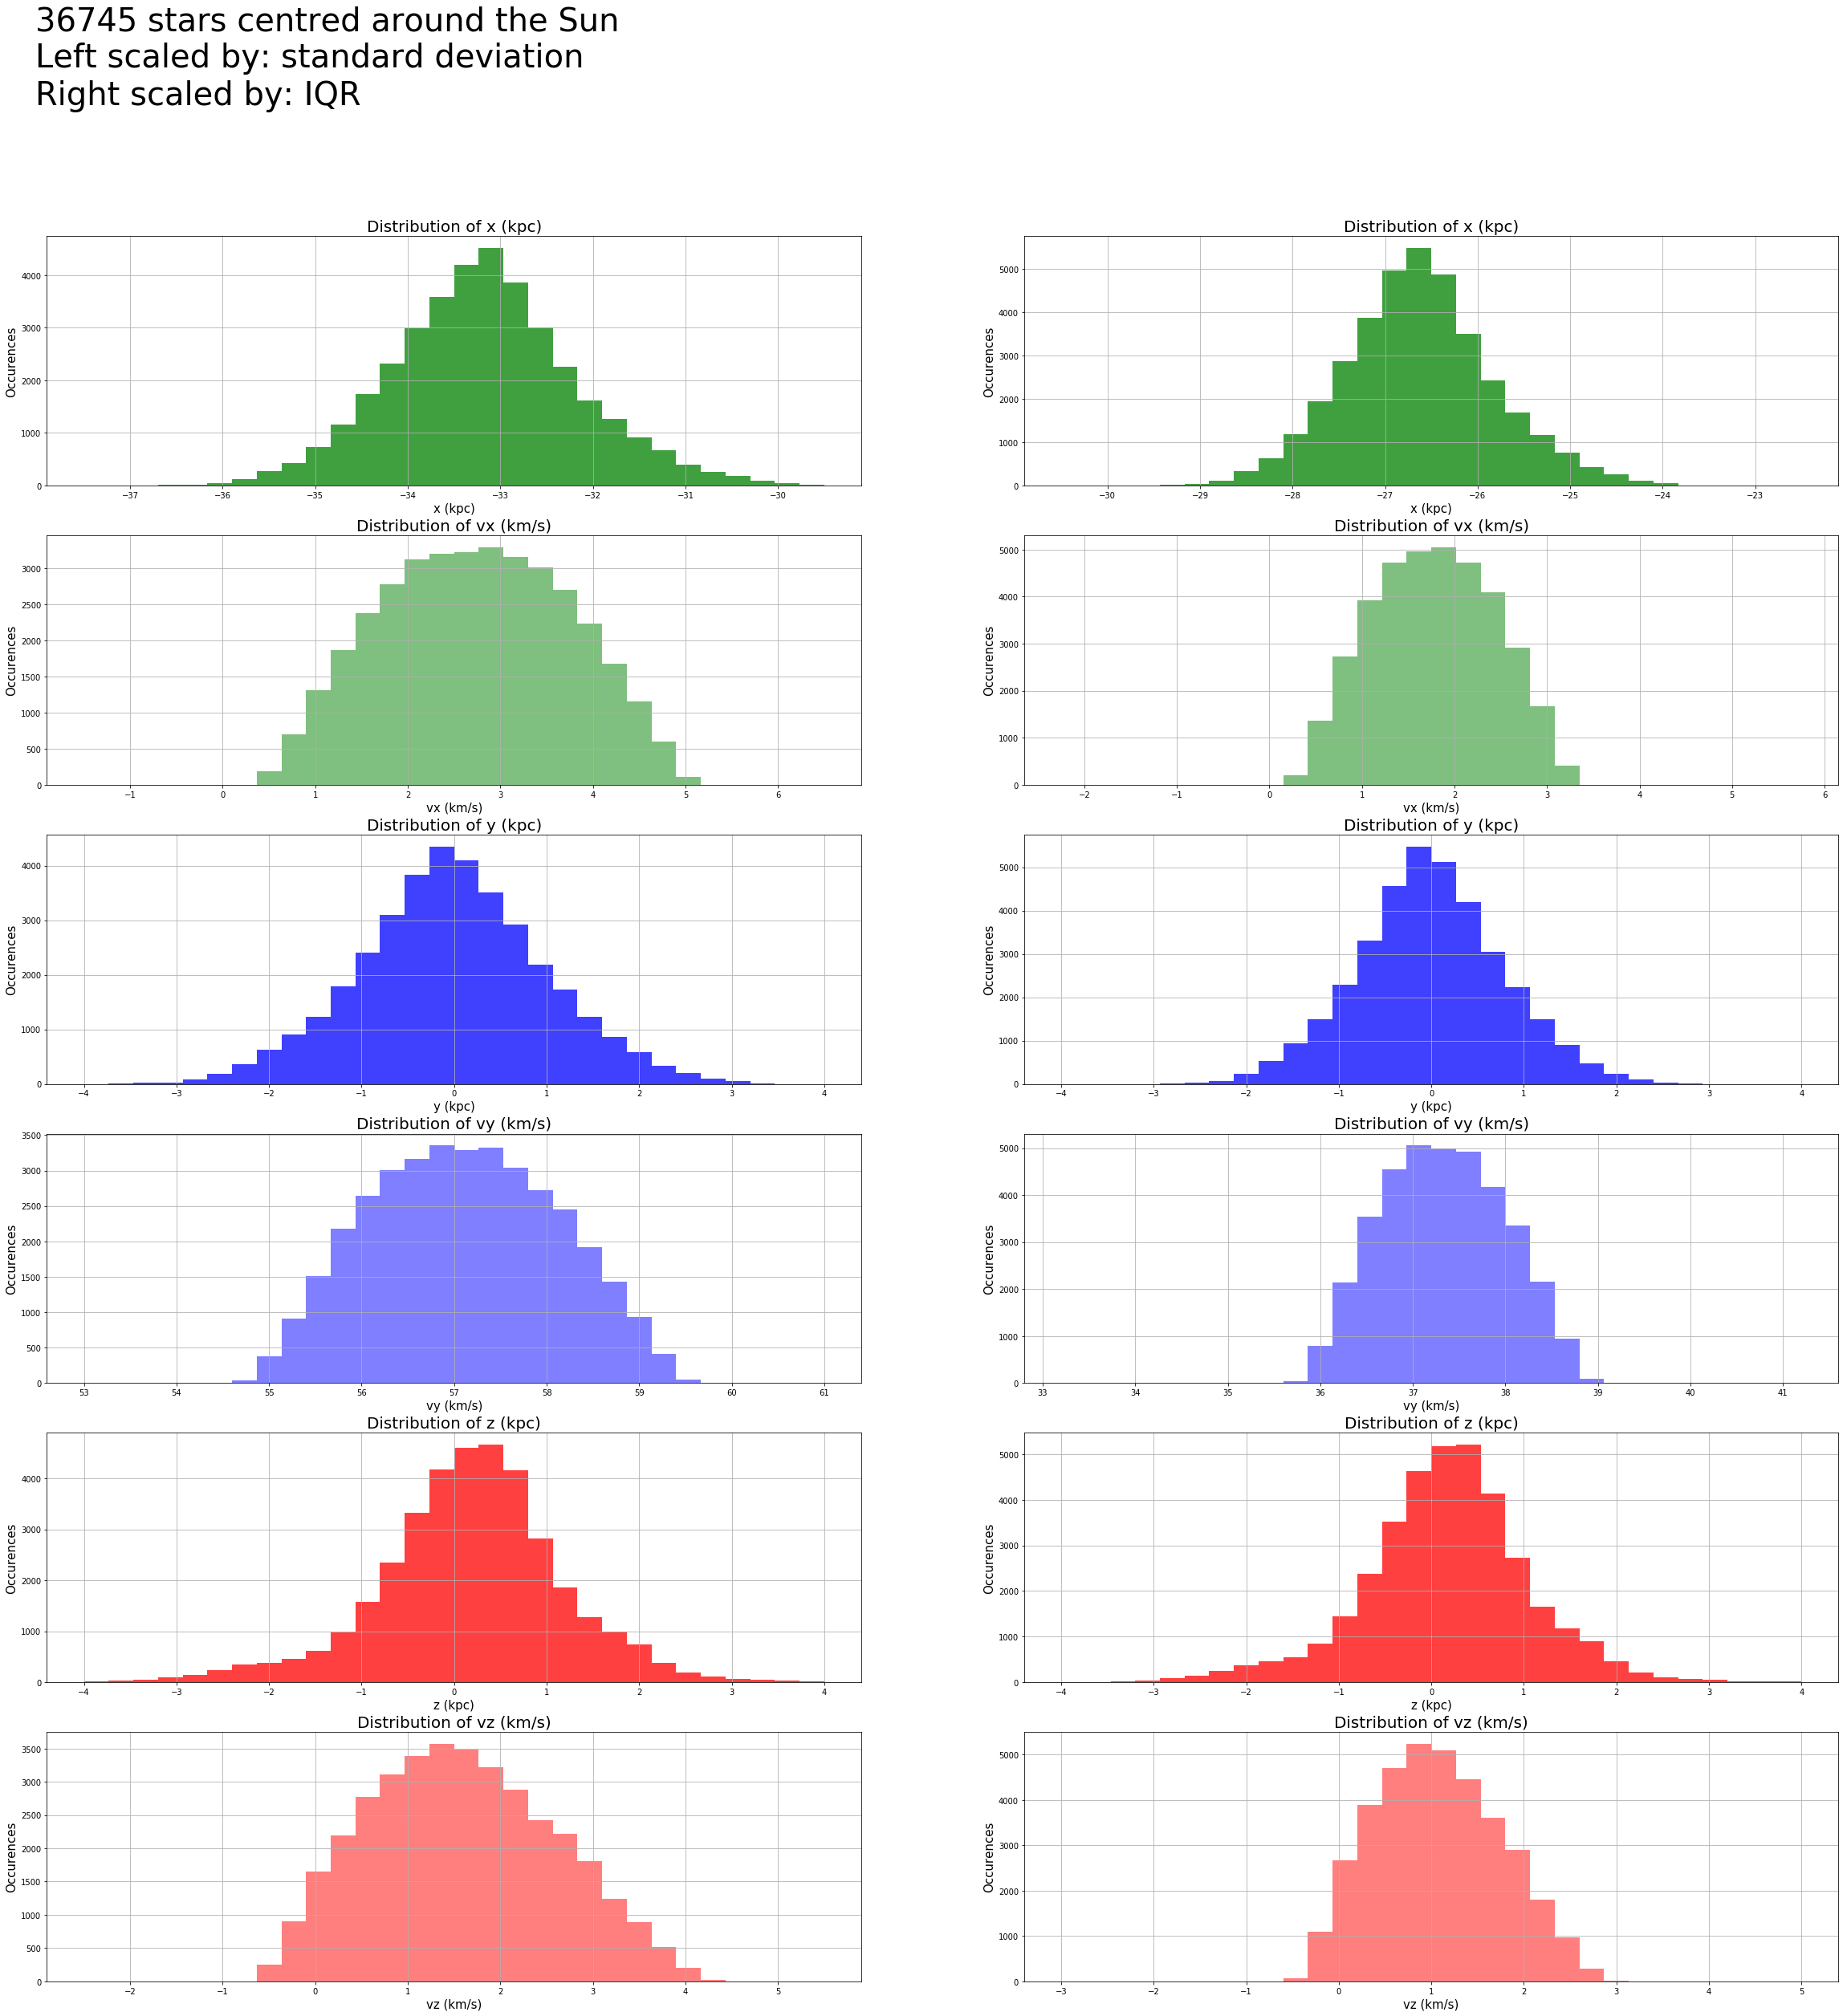

In [71]:
fig = plt.figure(figsize=(40, 40))
gs = gridspec.GridSpec(6, 2) 
fig.suptitle("36745 stars centred around the Sun \nLeft scaled by: standard deviation \nRight scaled by: IQR", fontsize=40, horizontalalignment='left', x=0.12)

#
# ROW 1(x)
#

std_x = np.std(samples_large[:, 0])
iqr_x = iqr(samples_large[:, 0])

ax1 = fig.add_subplot(gs[0])
n, bins, patches = plt.hist(np.divide(samples_large[:, 0].flatten(), std_x), bins=30, range=(-37.5, -29.5), facecolor='green', alpha=0.75)
plt.xlabel('x (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of x (kpc)', fontsize=20)
plt.grid(True)

ax2 = fig.add_subplot(gs[1])
n, bins, patches = plt.hist(np.divide(samples_large[:, 0].flatten(), iqr_x), bins=30, range=(-30.5, -22.5), facecolor='green', alpha=0.75)
plt.xlabel('x (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of x (kpc)', fontsize=20)
plt.grid(True)


#
# ROW 2(vx)
#

std_vx = np.std(samples_large[:, 3])
iqr_vx = iqr(samples_large[:, 3])

ax3 = fig.add_subplot(gs[2])
n, bins, patches = plt.hist(np.divide(samples_large[:, 3].flatten(), std_vx), bins=30, range=(-1.5, 6.5), facecolor='green', alpha=0.5)
plt.xlabel('vx (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of vx (km/s)', fontsize=20)
plt.grid(True)

ax4 = fig.add_subplot(gs[3])
n, bins, patches = plt.hist(np.divide(samples_large[:, 3].flatten(), iqr_vx), bins=30, range=(-2.25, 5.75), facecolor='green', alpha=0.5)
plt.xlabel('vx (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of vx (km/s)', fontsize=20)
plt.grid(True)


#
# ROW 3(y)
#

std_y = np.std(samples_large[:, 1])
iqr_y = iqr(samples_large[:, 1])

ax5 = fig.add_subplot(gs[4])
n, bins, patches = plt.hist(np.divide(samples_large[:, 1].flatten(), std_y), bins=30, range=(-4, 4), facecolor='blue', alpha=0.75)
plt.xlabel('y (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of y (kpc)', fontsize=20)
plt.grid(True)

ax6 = fig.add_subplot(gs[5])
n, bins, patches = plt.hist(np.divide(samples_large[:, 1].flatten(), iqr_y), bins=30, range=(-4, 4), facecolor='blue', alpha=0.75)
plt.xlabel('y (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of y (kpc)', fontsize=20)
plt.grid(True)


#
# ROW 4(vy)
#

std_vy = np.std(samples_large[:, 4])
iqr_vy = iqr(samples_large[:, 4])


ax7 = fig.add_subplot(gs[6])
n, bins, patches = plt.hist(np.divide(samples_large[:, 4].flatten(), std_vy), bins=30, range=(53, 61), facecolor='blue', alpha=0.5)
plt.xlabel('vy (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of vy (km/s)', fontsize=20)
plt.grid(True)

ax8 = fig.add_subplot(gs[7])
n, bins, patches = plt.hist(np.divide(samples_large[:, 4].flatten(), iqr_vy), bins=30, range=(33.2, 41.2), facecolor='blue', alpha=0.5)
plt.xlabel('vy (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of vy (km/s)', fontsize=20)
plt.grid(True)


#
# ROW 5(z)
#

std_z = np.std(samples_large[:, 2])
iqr_z = iqr(samples_large[:, 2])

ax9 = fig.add_subplot(gs[8])
n, bins, patches = plt.hist(np.divide(samples_large[:, 2].flatten(), std_z), bins=30, range=(-4, 4), facecolor='red', alpha=0.75)
plt.xlabel('z (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of z (kpc)', fontsize=20)
plt.grid(True)

ax10 = fig.add_subplot(gs[9])
n, bins, patches = plt.hist(np.divide(samples_large[:, 2].flatten(), iqr_z), bins=30, range=(-4, 4), facecolor='red', alpha=0.75)
plt.xlabel('z (kpc)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of z (kpc)', fontsize=20)
plt.grid(True)


#
# ROW 6(vz)
#

std_vz = np.std(samples_large[:, 5])
iqr_vz = iqr(samples_large[:, 5])

ax11 = fig.add_subplot(gs[10])
n, bins, patches = plt.hist(np.divide(samples_large[:, 5].flatten(), std_vz), bins=30, range=(-2.5, 5.5), facecolor='red', alpha=0.5)
plt.xlabel('vz (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of vz (km/s)', fontsize=20)
plt.grid(True)

ax12 = fig.add_subplot(gs[11])
n, bins, patches = plt.hist(np.divide(samples_large[:, 5].flatten(), iqr_vz), bins=30, range=(-3, 5), facecolor='red', alpha=0.5)
plt.xlabel('vz (km/s)', fontsize=15)
plt.ylabel('Occurences', fontsize=15)
plt.title('Distribution of vz (km/s)', fontsize=20)
plt.grid(True)


plt.show()
fig.savefig("Defining_kmeans_images/comparison_36745stars.png")


It seems like IQR is better if there are outliers, but we can use a 3 Standard Deviation cut to the original data to account for that. We choose using std to run in KMeans.

### How does KMeans MiniBatch work?<a class="anchor" id="second-bullet"></a>

### Runtime Comparison Between KMeans & KMeans MiniBatch<a class="anchor" id="third-bullet"></a>

>| Sample size | Dimensions (x, y, z, vx, vy, vz) | # of Clusters | Runtime |
 | ----------- | ---------------------------------| ------------- | ------- |
 | 100     | right-aligned | $1600 |
 | col 2 is      | centered      |   $12 |
 | zebra stripes | are neat      |    $1 |

In [11]:
min(samples[:,1])

-0.2677155111677415

In [12]:
print()

In [13]:
n

array([  0.,   0.,   0.,   0.,   0.,   1.,   2.,  11.,  17.,   9.,  11.,
        23.,  18.,  17.,  17.,  24.,  21.,  15.,   9.,   5.,   1.,   4.,
         2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

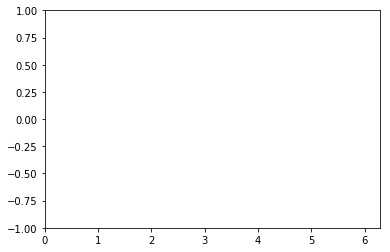

In [14]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
xdata, ydata = [],[]
ln, = plt.plot([], [], 'ro', animated=True)

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
plt.show()

In [15]:
from galpy.potential import MWPotential2014
MWPotential2014